# T-SNE on Amazon Food Reviews Using Average w2v Technique

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using Avg w2v technique then plot T-SNE. Separate all positive and negative reviews by blue and red colors respectively.**

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data The dataset is available in two forms

1) .csv file

2) SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import nltk             #nltk = natural language tool kit
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [3]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [4]:
data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'have bought sever the vital can dog food pro...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut the pe...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'this confect that has been around few centur...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price there was wide assor...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,b'got wild hair for taffi and order this five ...


In [5]:
data.shape

(364171, 12)

In [6]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [7]:
allPositiveReviews = pd.read_sql_query("SELECT * FROM Reviews WHERE Score = 'Positive'", connection)

In [8]:
allPositiveReviews.shape

(307061, 12)

In [9]:
allNegativeReviews = pd.read_sql_query("SELECT * FROM Reviews WHERE Score = 'Negative'", connection)

In [10]:
allNegativeReviews.shape

(57110, 12)

In [11]:
positiveReviews_5000 = allPositiveReviews[:5000]

In [12]:
print(positiveReviews_5000.shape)

(5000, 12)


In [13]:
positiveReviews_5000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'have bought sever the vital can dog food pro...
1,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'this confect that has been around few centur...
2,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price there was wide assor...
3,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,b'got wild hair for taffi and order this five ...
4,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,Positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,b'this saltwat taffi had great flavor and was ...


In [14]:
negativeReviews_5000 = allNegativeReviews[:5000]

In [15]:
print(negativeReviews_5000.shape)

(5000, 12)


In [16]:
negativeReviews_5000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut the pe...
1,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,Negative,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,b'cat have been happili eat felida platinum fo...
2,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,Negative,1348099200,poor taste,I love eating them and they are good for watch...,b'love eat them and they are good for watch an...
3,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,Negative,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",b'the candi just red flavor just plan and chew...
4,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,Negative,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",b'this oatmeal not good it mushi soft dont lik...


In [17]:
frames_10000 = [positiveReviews_5000, negativeReviews_5000]

In [18]:
FinalPositiveNegative = pd.concat(frames_10000)

In [19]:
FinalPositiveNegative.shape

(10000, 12)

In [20]:
# Sorting dataframe by 'Time'
FinalSortedPositiveNegative_10000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [21]:
FinalSortedPositiveNegativeScore_10000 = FinalSortedPositiveNegative_10000["Score"]

In [22]:
print(FinalSortedPositiveNegative_10000.shape)
print(FinalSortedPositiveNegativeScore_10000.shape)

(10000, 12)
(10000,)


In [23]:
FinalSortedPositiveNegative_10000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
649,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,Positive,961718400,Great Product,This was a really good idea and the final prod...,b'this was realli good idea and the final prod...
648,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,Positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'just receiv shipment and could hard wait tri...
4923,7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,Positive,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,b'the winter when fresh blueberri exceed our f...
2030,3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,Positive,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,b'mae ploy sweet chili sauc becom standard con...
4388,6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,Positive,1083456000,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,b'love the snack want buy bunch ship amazon mo...


## Avg w2v

In [24]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\GauravP\Anaconda3\lib\site-packages\gensim-3.2.0-py3.6-win-amd64.egg\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [25]:
i = 0
listOfSentences = []
for sentence in FinalSortedPositiveNegative_10000["Text"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [26]:
print(FinalSortedPositiveNegative_10000['Text'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


[['This', 'was', 'a', 'really', 'good', 'idea', 'and', 'the', 'final', 'product', 'is', 'outstanding.', 'I', 'use', 'the', 'decals', 'on', 'my', 'car', 'window', 'and', 'everybody', 'asks', 'where', 'i', 'bought', 'the', 'decals', 'i', 'made.', 'Two', 'thumbs', 'up!'], ['I', 'just', 'received', 'my', 'shipment', 'and', 'could', 'hardly', 'wait', 'to', 'try', 'this', 'product.', 'We', 'love', '&quot;slickers&quot;', 'which', 'is', 'what', 'we', 'call', 'them,', 'instead', 'of', 'stickers', 'because', 'they', 'can', 'be', 'removed', 'so', 'easily.', 'My', 'daughter', 'designed', 'signs', 'to', 'be', 'printed', 'in', 'reverse', 'to', 'use', 'on', 'her', 'car', 'windows.', 'They', 'printed', 'beautifully', '(we', 'have', "'The", 'Print', "Shop'", 'program).', 'I', 'am', 'going', 'to', 'have', 'a', 'lot', 'of', 'fun', 'wit

In [27]:
import gensim
w2vModel = gensim.models.Word2Vec(listOfSentences, size=100, min_count=5, workers=4)

In [28]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(100)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    sentenceVector /= TotalWordsPerSentence
    sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
10000
100


In [29]:
from sklearn.preprocessing import StandardScaler
standardized_Avg_w2v = StandardScaler().fit_transform(sentenceAsW2V)
print(standardized_Avg_w2v.shape)
print(type(standardized_Avg_w2v))

(10000, 100)
<class 'numpy.ndarray'>


## TSNE of Avg w2v

In [42]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=5000, n_iter=2500)

tsne_data = model.fit_transform(standardized_Avg_w2v)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_10000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

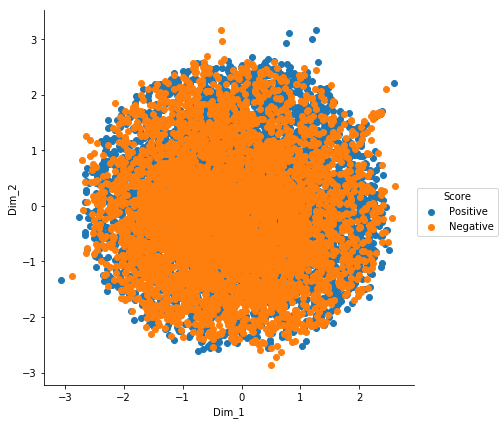

In [43]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()

In [30]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=2500)

tsne_data = model.fit_transform(standardized_Avg_w2v)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_10000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

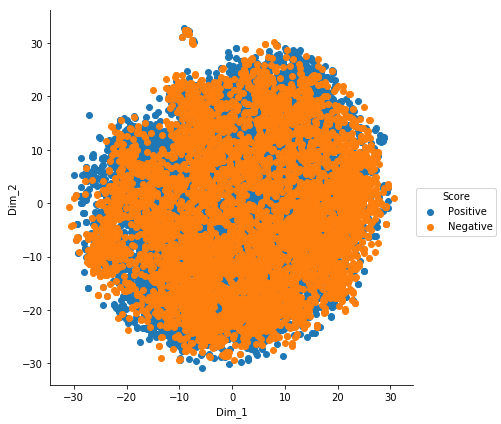

In [31]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()